### Simple language model to process user events

In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

data_dir = 'data/char_feats/U1480/'


TensorFlow version: 1.7.0
Eager execution: True


In [33]:
# transform character-based input into equivalent numerical versions
def encode_data(text, num_chars, max_length):
    # create empty vessels for one-hot encoded input
    X = np.zeros((len(text), max_length, num_chars), dtype=np.float32)
    y = np.zeros((len(text), max_length, num_chars), dtype=np.float32)
    
    # loop over inputs and tranform and store in X
    for i, sentence in enumerate(text):
        sentence = '\t' + sentence + '\n'
        for j, c in enumerate(sentence):
            X[i, j, ord(c)] = 1
            if j > 0:
                # target_data will be ahead by one timestep
                # and will not include the start character.
                y[i, j - 1, ord(c)] = 1.

    return X, y

In [81]:
def process_file(fname):
    """
        process file by extracting sentences data and encode them producing 
        a set of input and target data for processing by the model
        'fname' contains coma separated fields where the last one is the 
        sentence to be processes
    """
    data = open(fname).read()
    max_len = 120 # length of sentence

    text = []
    red_events = []
    with open(dataset_fname, 'r') as infile:
        for line in infile.readlines():
            line = line.strip().split(',')
            text.append(line[-1])
            if int(line[2]) == 1:
                red_events.append(line)

    print(text[0], 'len:', len(text[0]), len(text))

    input_data, target_data = encode_data(text, 128, max_len)
    
    return input_data, target_data, red_events
    

In [74]:
dataset_fname = data_dir+'0.txt'

input_data, target_data = process_file(dataset_fname)


print(input_data.shape)
print(target_data.shape)

(629, 120, 128)
(629, 120, 128)


### Create a model using Keras

The TensorFlow [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras) API is the preferred way to create models and layers. This makes it easy to build models and experiment while Keras handles the complexity of connecting everything together. See the [Keras documentation](https://keras.io/) for details.

The [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model is a linear stack of layers. Its constructor takes a list of layer instances, in this case, one [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) and one [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layers with 'num_chars' nodes each. The first layer's `input_shape` parameter corresponds to the amount of features from the dataset, and is required.

In [64]:
num_chars = 128 # our vocabulary, i.e. unique characters in text. We'll just use the first 128 (half ASCII)

def getModel():
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(num_chars, input_shape=(None, num_chars), return_sequences=True),  # input shape required
        tf.keras.layers.Dense(num_chars, activation="softmax"),
    ])
    return model

### Train the model

#### Define the loss and gradient function

Both training and evaluation stages need to calculate the model's *[loss](https://developers.google.com/machine-learning/crash-course/glossary#loss)*. This measures how off a model's predictions are from the desired output. We want to minimize, or optimize, this value.

Our model will calculate its loss using the [tf.keras.losses.categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/categorical_crossentropy) function which takes the model's prediction and the desired output. The returned loss value is progressively larger as the prediction gets worse.

The `grad` function uses the `loss` function and the [tfe.GradientTape](https://www.tensorflow.org/api_docs/python/tf/contrib/eager/GradientTape) to record operations that compute the *[gradients](https://developers.google.com/machine-learning/crash-course/glossary#gradient)* used to optimize our model.

In [68]:
def loss(model, x, y):
    y_ = model(x)
    return tf.keras.losses.categorical_crossentropy(y, y_)

def grad(model, inputs, targets):
    with tfe.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, model.variables)

#### Define the optimizer
TensorFlow has many [optimization algorithms](https://www.tensorflow.org/api_guides/python/train) available for training. This model uses the [tf.train.GradientDescentOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer) that implements the *[stochastic gradient descent](https://developers.google.com/machine-learning/crash-course/glossary#gradient_descent)* (SGD) algorithm. The `learning_rate` sets the step size to take for each iteration down the hill. 

In [69]:
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001, epsilon=1e-08)

#### Training the model

In [70]:
import time

num_epochs = 10
batch_size = 100

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

training_dataset = tf.data.Dataset.from_tensor_slices((input_data, target_data))
training_dataset = training_dataset.batch(batch_size)
print(training_dataset)

model = getModel()

for epoch in range(num_epochs):
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()
    
    startTime = time.time()
    # training using batches of 'batch_size'
    for X, y in tfe.Iterator(training_dataset):
        grads = grad(model, X, y)
        optimizer.apply_gradients(zip(grads, model.variables), 
                                 global_step=tf.train.get_or_create_global_step())
        epoch_loss_avg(loss(model, X, y)) # batch loss
        epoch_accuracy(model(X), y)
        
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
    if epoch % 1 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%} - in: {:.3f} sec.".format(epoch, 
                                                                    epoch_loss_avg.result(), 
                                                                    epoch_accuracy.result(),
                                                                    (time.time()-startTime)))        


<BatchDataset shapes: ((?, 120, 128), (?, 120, 128)), types: (tf.float32, tf.float32)>
Epoch 000: Loss: 2.196, Accuracy: 0.000% - in: 16.901 sec.
Epoch 001: Loss: 1.760, Accuracy: 0.000% - in: 16.693 sec.
Epoch 002: Loss: 1.659, Accuracy: 0.000% - in: 16.726 sec.
Epoch 003: Loss: 1.615, Accuracy: 0.000% - in: 16.633 sec.
Epoch 004: Loss: 1.561, Accuracy: 0.000% - in: 16.699 sec.
Epoch 005: Loss: 1.540, Accuracy: 0.000% - in: 17.152 sec.
Epoch 006: Loss: 1.478, Accuracy: 0.000% - in: 17.593 sec.
Epoch 007: Loss: 1.440, Accuracy: 0.000% - in: 17.039 sec.
Epoch 008: Loss: 1.470, Accuracy: 0.000% - in: 16.734 sec.
Epoch 009: Loss: 1.392, Accuracy: 0.000% - in: 16.680 sec.


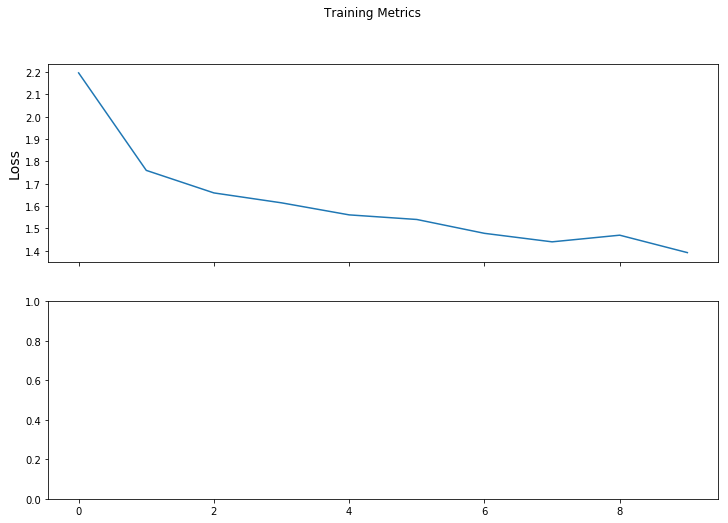

In [71]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

# axes[1].set_ylabel("Accuracy", fontsize=14)
# axes[1].set_xlabel("Epoch", fontsize=14)
# axes[1].plot(train_accuracy_results)

plt.show()

#### Save model to a file

In [75]:
model_filepath = 'models/model_lm_v1.hdfs'

tf.keras.models.save_model(
    model,
    model_filepath,
    overwrite=True,
    include_optimizer=True
)

In [90]:
dataset_fname = data_dir+'12.txt'

input_data, target_data, red_events = process_file(dataset_fname)

print(input_data.shape)
print(target_data.shape)
print(len(red_events))

U1480@DOM1|U1480@DOM1|C12512|C2310|?|?|AuthMap|Success len: 54 808
(808, 120, 128)
(808, 120, 128)
2


In [93]:
_dataset = tf.data.Dataset.from_tensor_slices((input_data, target_data))
_dataset = training_dataset.batch(batch_size)

# training using batches of 'batch_size'
for X, y in tfe.Iterator(training_dataset):
    line_losses = tf.reduce_mean(loss(model, X, y), axis=1)
    break

avgloss = tf.reduce_mean(line_losses)  # scalar



In [95]:
print(line_losses - avgloss)
print(avgloss)

tf.Tensor(
[ 0.05981135  0.0225805  -0.12406158 -0.144153   -0.14090693 -0.14090693
 -0.1553986   0.24486184 -0.18014288 -0.17335153  0.22779965 -0.19027913
  0.21200383 -0.18041813  0.22123873 -0.18701124  0.21518683  0.01052046
  0.00100446  0.02025092 -0.14090693 -0.13864899 -0.12406158 -0.18014288
  0.05955553  0.22123873  0.02025092  0.2274909   0.12310028 -0.14090693
  0.1807859   0.21518683  0.01052046  0.24486184 -0.1553986  -0.19026577
  0.21177852 -0.18041813  0.00746942  0.02025092  0.03699899  0.22779965
  0.24486184  0.171368    0.0644908   0.24656284  0.22123873  0.21200383
  0.02025092 -0.12406158 -0.144153   -0.14090693 -0.14090693 -0.1553986
 -0.18014288 -0.17335153 -0.19027913 -0.18041813  0.22123873 -0.18701124
  0.00100446  0.02025092 -0.13864899 -0.12406158 -0.14090693 -0.18014288
 -0.14090693 -0.1553986  -0.19026577  0.21177852 -0.18041813  0.00746942
  0.06493533  0.02025092  0.05955553  0.07732272  0.00100446  0.07732272
  0.00100446  0.25939023 -0.18041813 -0.1